In [1]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def compute_mask(pattern, im_shape):
    """Create Bayer pattern mask."""
    if pattern != 'bayer_rggb':
        raise NotImplementedError('Only bayer_rggb is implemented')
        
    r_mask = np.zeros(im_shape)
    r_mask[0::2, 0::2] = 1

    g_mask = np.zeros(im_shape)
    g_mask[::2, 1::2] = 1
    g_mask[1::2, ::2] = 1

    b_mask = np.zeros(im_shape)
    b_mask[1::2, 1::2] = 1
    
    mask = np.zeros(im_shape + (3,))
    mask[:, :, 0] = r_mask
    mask[:, :, 1] = g_mask
    mask[:, :, 2] = b_mask
    
    return mask

def process_image(image_path):
    """Process single image to create Bayer pattern."""
    # Read RGB image
    image_gt = cv2.imread(str(image_path))
    b, g, r = cv2.split(image_gt)
    image_gt = cv2.merge([r, g, b])  # BGR to RGB
    
    # Compute mask
    mask = compute_mask('bayer_rggb', image_gt.shape[:2])
    mask = mask.astype(np.int32)
    
    # Apply mask to create mosaic
    image_mosaic = np.zeros(image_gt.shape).astype(np.int32)
    image_mosaic[:, :, 0] = mask[..., 0] * image_gt[..., 0]
    image_mosaic[:, :, 1] = mask[..., 1] * image_gt[..., 1]
    image_mosaic[:, :, 2] = mask[..., 2] * image_gt[..., 2]
    
    # Sum channels to get Bayer pattern
    image_input = np.sum(image_mosaic, axis=2, dtype='uint16')
    
    return image_gt, mask, image_mosaic, image_input

In [5]:
def visualize_sample_images(dataset_path, num_samples=3):
    image_paths = list(Path(dataset_path).glob('*.png'))
    selected_paths = np.random.choice(image_paths, num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i, path in enumerate(selected_paths):
        image_gt, mask, image_mosaic, image_input = process_image(path)
        
        axes[i,0].imshow(image_gt)
        axes[i,0].set_title(f'Original RGB - {path.name}')
        axes[i,0].axis('off')
        
        axes[i,1].imshow(mask)
        axes[i,1].set_title('Bayer Mask')
        axes[i,1].axis('off')
        
        axes[i,2].imshow(image_mosaic/255)
        axes[i,2].set_title('Masked RGB')
        axes[i,2].axis('off')
        
        axes[i,3].imshow(image_input, cmap='gray')
        axes[i,3].set_title('Bayer Pattern')
        axes[i,3].axis('off')
    
    plt.tight_layout()
    plt.show()

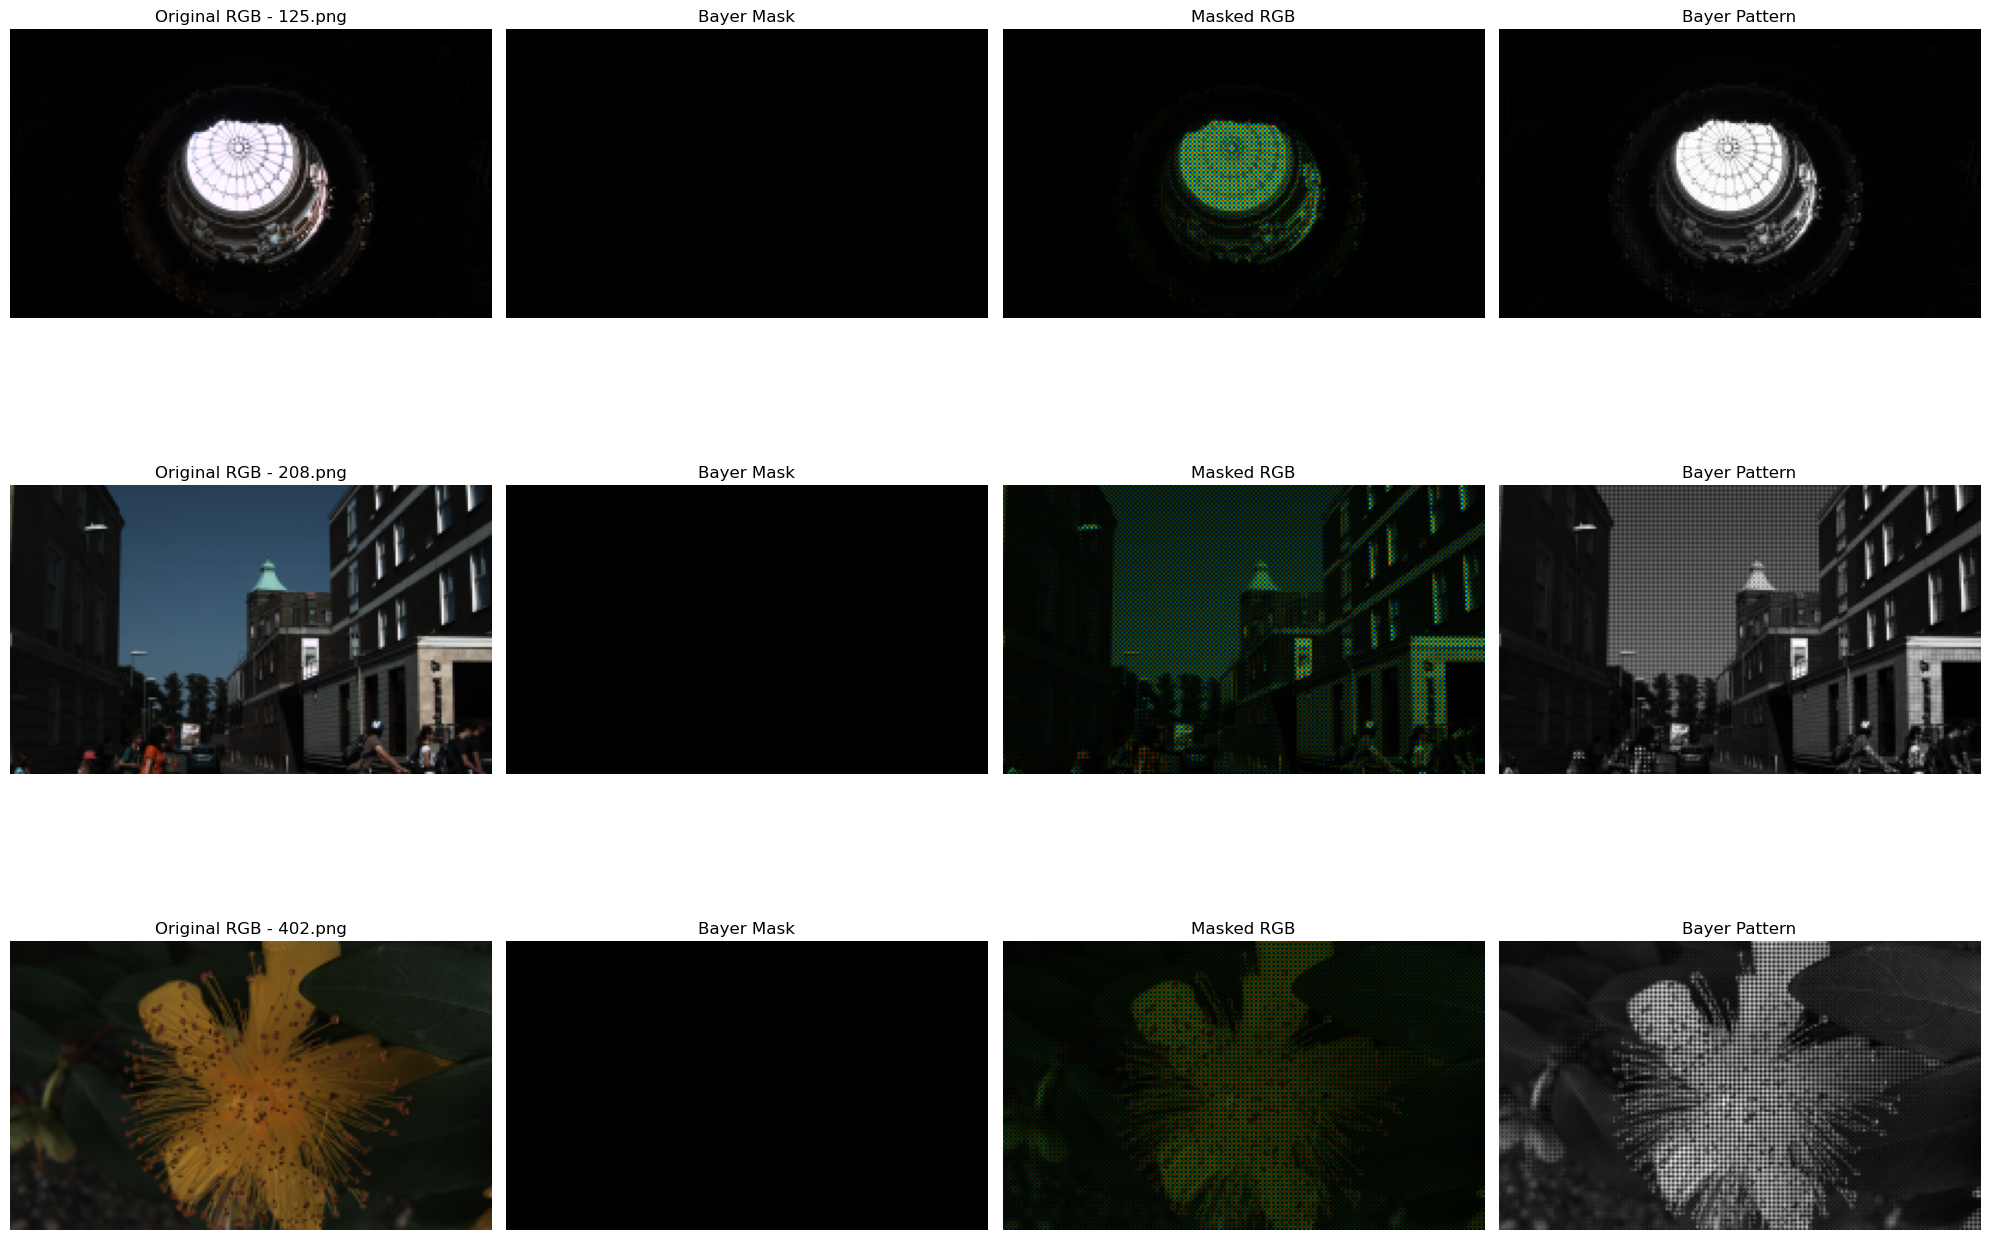

In [6]:
# Visualize samples
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/groundtruth'
visualize_sample_images(dataset_path, num_samples=3)

In [ ]:
# Visualize samples
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/input'
visualize_sample_images(dataset_path, num_samples=3)

In [ ]:
def verify_bayer_pattern(input_path, reconstructed_path):
    # Read original input
    original = cv2.imread(str(input_path), cv2.IMREAD_UNCHANGED)
    original = original.astype(np.float32) / 65535.0
    
    # Read reconstructed input 
    reconstructed = cv2.imread(str(reconstructed_path), cv2.IMREAD_UNCHANGED)
    reconstructed = reconstructed.astype(np.float32) / 65535.0
    
    # Compare
    diff = np.abs(original - reconstructed)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Input')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title('Reconstructed Input')
    axes[1].axis('off')
    
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title(f'Difference\nMax: {max_diff:.6f}\nMean: {mean_diff:.6f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Test with one sample
input_dir = Path('dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/input')
gt_dir = Path('dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic/groundtruth')

sample_input = list(input_dir.glob('*.png'))[0]
sample_gt = gt_dir / sample_input.name

verify_bayer_pattern(sample_input, sample_gt)